## Performance Analysis of Traditional vs. Contiguous-Memory String Operations

### Part 1 - Import Libraries and Prepare Data

In [21]:
# Importing necessary libraries
import pyarrow as pa
import pyarrow.compute as pc
import time
import pandas as pd
import numpy as np
import sys
from memory_profiler import memory_usage
import matplotlib.pyplot as plt

# Create sample data - A list of strings that we will use for our tests, replicated for volume
data = ["hello world", "data science", "machine learning", "python programming"] * 100000

# Create a DataFrame for traditional string operations
traditional_df = pd.DataFrame(data, columns=["text"])

# Create a PyArrow array for efficient contiguous-data based operations
arrow_array = pa.array(data)

### Part 2 - Performance Measurement Function

In [2]:
# Create a function to measure the time and memory usage of an operation
def measure_performance(operation, data):
    """
    This function measures the execution time and memory usage of a string operation
    """
    start_time = time.time()        # Start time
    mem_before = memory_usage()[0]  # Memory usage before
    result = operation(data)        # Run the operation
    mem_after = memory_usage()[0]   # Memory usage after
    end_time = time.time()          # End time
    
    return {
        "Result": result,
        "Time Taken (s)": end_time - start_time,
        "Memory Usage (MB)": mem_after - mem_before
    }

### Part 3 - Define String Operations

In [3]:
# Define the string operations needed to test for both Traditional and PyArrow

# Each string operation is defined here as a small function (using lambda functions)

traditional_operations = {
    "Reverse String": lambda x: x[::-1],            
    "Uppercase": lambda x: x.upper(),               
    "Lowercase": lambda x: x.lower(),               
    "Concatenate with ' - test'": lambda x: x + ' - test',  
    "Find Substring 'data'": lambda x: 'data' in x, 
    "Replace 'data' with 'info'": lambda x: x.replace('data', 'info'),
    "Split by Space": lambda x: x.split(' ')
}

# Define corresponding equivalent operations for PyArrow
arrow_operations = {
    "Reverse String": lambda x: pc.binary_reverse(pc.cast(x, pa.binary())),
    "Uppercase": lambda x: pc.utf8_upper(x),
    "Lowercase": lambda x: pc.utf8_lower(x),
    "Concatenate with ' - test'": lambda x: pc.binary_join_element_wise(x, pa.array([' - test'] * len(x))),
    "Find Substring 'data'": lambda x: pc.match_substring(x, "data"),
    "Replace 'data' with 'info'": lambda x: pc.replace_substring(x, "data", "info"),
    "Split by Space": lambda x: pc.split_pattern(x, " ")
}


### Part 4 - Run Operations and Collect Results

In [4]:
# The 'results' list will store the results for both Traditional and PyArrow methods
results = []


# For Trsditional Operations:
print("Running traditional string operations and saving results.")
for operation_name, operation in traditional_operations.items(): 
    
    # Measure performance
    performance = measure_performance(
        lambda df: df['text'].apply(operation), traditional_df
    )
    
    # Store the results
    results.append({
        "Operation": operation_name,
        "Method": "Traditional",
        "Time Taken (s)": performance["Time Taken (s)"],
        "Memory Usage (MB)": performance["Memory Usage (MB)"]
    })

    
# For PyArrow Operations:    
print("Running PyArrow string operations and saving the results.")
for operation_name, operation in arrow_operations.items():
    
    # Measure performance
    performance = measure_performance(operation, arrow_array)
    
    # Store the results
    results.append({
        "Operation": operation_name,
        "Method": "PyArrow",
        "Time Taken (s)": performance["Time Taken (s)"],
        "Memory Usage (MB)": performance["Memory Usage (MB)"]
    })

Running traditional string operations and saving results.
Running PyArrow string operations and saving the results.


### Part 5 - Create DataFrame and Save Results

In [20]:
# Create a DataFrame to display the summary of results
results_df = pd.DataFrame(results)

# Display the results in a summary table
print("Summary of Results:")
print(results_df)

# Save the results to a CSV
results_df.to_csv("string_operations_performance.csv", index=False)

Summary of Results:
                     Operation       Method  Time Taken (s)  Memory Usage (MB)
0               Reverse String  Traditional        0.338504          31.269531
1                    Uppercase  Traditional        0.336496          31.128906
2                    Lowercase  Traditional        0.283842          30.304688
3   Concatenate with ' - test'  Traditional        0.314015          33.984375
4        Find Substring 'data'  Traditional        0.319377           0.175781
5   Replace 'data' with 'info'  Traditional        0.343005           8.132812
6               Split by Space  Traditional        0.718644         114.683594
7               Reverse String      PyArrow        0.227868           0.433594
8                    Uppercase      PyArrow        0.254368           7.078125
9                    Lowercase      PyArrow        0.245086           5.445312
10  Concatenate with ' - test'      PyArrow        0.266986           0.609375
11       Find Substring 'data'  

#### Computing average percentage difference in execution time and memory usage

In [25]:
# Group by Method and compute average time and memory usage
average_results = results_df.groupby('Method').mean()[['Time Taken (s)', 'Memory Usage (MB)']]

# Calculate the difference between Traditional and PyArrow
average_results.loc['Difference'] = average_results.loc['Traditional'] - average_results.loc['PyArrow']

# Calculate the percentage difference
# Avoid division by zero by using np.where to handle cases where the denominator is 0
average_results.loc['Percentage Improvement (%)'] = np.where(
    average_results.loc['PyArrow'] != 0,
    (average_results.loc['Difference'] / average_results.loc['Traditional']) * 100,
    np.nan
)

# Display the results
print("\nAverage Time and Memory Usage Comparison (with Percentage Difference):\n")
print(average_results)


Average Time and Memory Usage Comparison (with Percentage Difference):

                            Time Taken (s)  Memory Usage (MB)
Method                                                       
PyArrow                           0.249262           2.686384
Traditional                       0.379126          35.668527
Difference                        0.129864          32.982143
Percentage Improvement (%)       34.253537          92.468475


### Part 6 - Plot Results

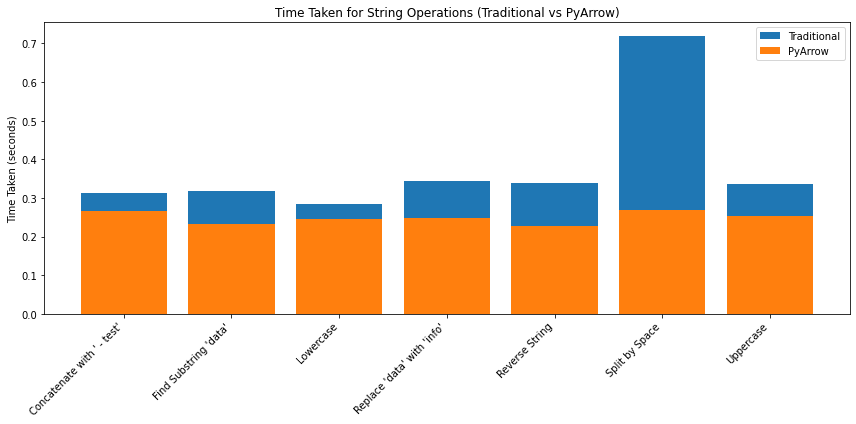

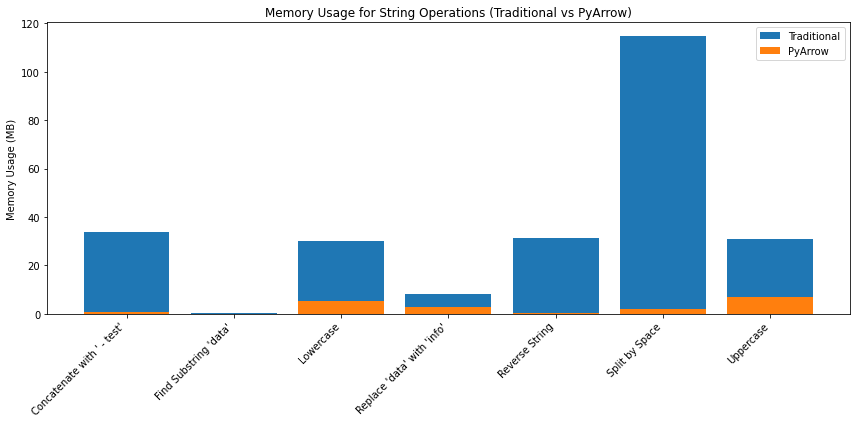

In [18]:
# Create a sorted list of operations - ensure the same operation for both 'Traditional' and 'PyArrow' is grouped together
sorted_operations = sorted(results_df['Operation'].unique(), key=lambda x: x.split(' (')[0])

# Add a 'Sort_Order' column to the DataFrame to maintain the order in the plot
results_df['Sort_Order'] = results_df['Operation'].apply(lambda x: sorted_operations.index(x))

# Sort the DataFrame based on 'Sort_Order' for proper grouping
results_df = results_df.sort_values(by='Sort_Order')

# Plot Time Taken for each operation
plt.figure(figsize=(12, 6))

# Loop through both methods ('Traditional' and 'PyArrow')
for method in results_df['Method'].unique():
    subset = results_df[results_df['Method'] == method]
    
    # Plot the bar for each method and label it
    plt.bar(subset['Operation'], subset['Time Taken (s)'], label=method)

plt.title("Time Taken for String Operations (Traditional vs PyArrow)")
plt.ylabel("Time Taken (seconds)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Plot the Memory Usage for each operation
plt.figure(figsize=(12, 6))

# Loop through each method ('Traditional' and 'PyArrow')
for method in results_df['Method'].unique():
    subset = results_df[results_df['Method'] == method]
    
    # Plot the bar for each method and label it
    plt.bar(subset['Operation'], subset['Memory Usage (MB)'], label=method)

plt.title("Memory Usage for String Operations (Traditional vs PyArrow)")
plt.ylabel("Memory Usage (MB)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

### Part 7 - Analyze the Results

In [7]:
# Analysis and Summary
print("Analysis Summary is as follows:")
for operation in results_df['Operation'].unique():
    traditional_time = results_df[(results_df['Operation'] == operation) & (results_df['Method'] == 'Traditional')]['Time Taken (s)'].values[0]
    arrow_time = results_df[(results_df['Operation'] == operation) & (results_df['Method'] == 'PyArrow')]['Time Taken (s)'].values[0]

    if traditional_time < arrow_time:
        print(f"- For '{operation}': Traditional is faster by {arrow_time - traditional_time:.4f} seconds.")
    else:
        print(f"- For '{operation}': PyArrow is faster by {traditional_time - arrow_time:.4f} seconds.")


Analysis Summary is as follows:
- For 'Reverse String': PyArrow is faster by 0.1106 seconds.
- For 'Uppercase': PyArrow is faster by 0.0821 seconds.
- For 'Lowercase': PyArrow is faster by 0.0388 seconds.
- For 'Concatenate with ' - test'': PyArrow is faster by 0.0470 seconds.
- For 'Find Substring 'data'': PyArrow is faster by 0.0863 seconds.
- For 'Replace 'data' with 'info'': PyArrow is faster by 0.0938 seconds.
- For 'Split by Space': PyArrow is faster by 0.4505 seconds.


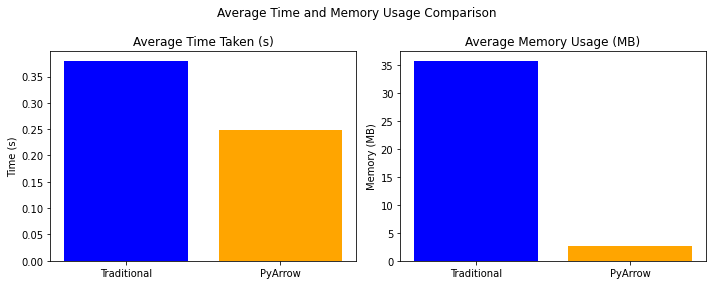

In [27]:
# Group by Method and compute average time and memory usage
average_results = results_df.groupby('Method').mean()[['Time Taken (s)', 'Memory Usage (MB)']]

# Plotting the comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Average Time and Memory Usage Comparison')

# Filter out 'Difference' before plotting
methods_to_plot = average_results.loc[['Traditional', 'PyArrow']]

# Time Taken Comparison
axes[0].bar(methods_to_plot.index, methods_to_plot['Time Taken (s)'], color=['blue', 'orange'])
axes[0].set_title('Average Time Taken (s)')
axes[0].set_ylabel('Time (s)')

# Memory Usage Comparison
axes[1].bar(methods_to_plot.index, methods_to_plot['Memory Usage (MB)'], color=['blue', 'orange'])
axes[1].set_title('Average Memory Usage (MB)')
axes[1].set_ylabel('Memory (MB)')

plt.tight_layout()
plt.show()